In [14]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn import datasets                              # 导入datasets模块，用于加载鸢尾花的数据集

iris_dataset = datasets.load_iris()                       # 加载鸢尾花的数据集，并存在iris_dataset

X_list = iris_dataset.data[:100, :].astype(np.float32)         # 选取iris_dataset的data的前100个数据，将其数据类型转换为float32，并储存在X中
X_feature_names = iris_dataset.feature_names              # 将iris_dataset的特征名称储存在X_feature_names中
Y_list = iris_dataset.target[:100].astype(int)                 # 选取iris_dataset的target的前100个数据，将其数据类型转换为int，并储存在y中
y_target_names = iris_dataset.target_names[:2]            # 选取iris_dataset的target_names的前2个数据，并储存在y_target_names中
print(X_list.shape)                                            # 打印样本的数据维度
print(Y_list)                                                  # 打印样本的标签的数组
print(X_list[0])
# 数据归一化
b=[[i for i in j] for j in X_list]
for i in range(100):
    for j in range(4):
        X_list[i][j] = X_list[i][j]/np.sqrt(b[i][0]**2+b [i][1]**2+b [i][2]**2+b[i][3]**2)
print(X_list[0])

(100, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[5.1 3.5 1.4 0.2]
[0.80377275 0.5516088  0.2206435  0.0315205 ]


In [15]:
def convertDataToAngles(data):
    prob1 = data[2] ** 2 + data[3] ** 2
    prob0 = 1 - prob1
    angle1 = 2 * np.arcsin(np.sqrt(prob1))
    prob1 = data[3] ** 2 / prob1
    angle2 = 2 * np.arcsin(np.sqrt(prob1))
    prob1 = data[1] ** 2 / prob0
    angle3 = 2 * np.arcsin(np.sqrt(prob1))
    return np.array([angle1, angle2, angle3])


def encodeData(qc, qreg, angles):
    qc.ry(angles[0], qreg[0])
    qc.cry(angles[1], qreg[0], qreg[1])
    qc.x(qreg[0])
    qc.cry(angles[2], qreg[0], qreg[1])
    qc.x(qreg[0])


def generateU(qc, qreg, params):
    qc.ry(np.pi/3,0)
    qc.ry(np.pi/3,1)
    for i in range(2):
        qc.rx(params[2*i][0][0],qreg[0])
        qc.rz(params[2*i+1][0][0],qreg[0])
        qc.rx(params[2*i][1][0],qreg[1])
        qc.rz(params[2*i+1][1][0],qreg[1])
        qc.cz(qreg[0],qreg[1])

        
def getPrediction(qc, qreg, creg, backend):
    qc.measure(qreg[-1], creg[0])
    job = execute(qc, backend=backend, shots=1000)
    results = job.result().get_counts()
    if '1' in results.keys():
        return results['1'] / 1000
    else:
        return 0


def convertToClass(predictions):
    return (predictions >= 0.5) * 1


def cost(labels, predictions):
    loss = 0
    for label, pred in zip(labels, predictions):
        loss += (pred - label) ** 2

    return loss / 2


def accuracy(labels, predictions):
    acc = 0
    for label, pred in zip(labels, predictions):
        if label == pred:
            acc += 1

    return acc / labels.shape[0]


def forwardPass(params, bias, angles, backend):
    qreg = QuantumRegister(2)
    creg = ClassicalRegister(1)
    qc = QuantumCircuit(qreg, creg)
    encodeData(qc, qreg, angles)
    generateU(qc, qreg, params)
    pred = getPrediction(qc, qreg, creg, backend) + bias
    return pred


def computeGradient(params, angles, label, bias, backend):
    prob = forwardPass(params, bias, angles, backend)
    gradients = np.zeros_like(params)
    for i in range(params.shape[0]):
        for j in range(params.shape[1]):
            newParams = np.copy(params)
            newParams[i, j, 0] += np.pi/2
            gradients[i, j, 0] = forwardPass(newParams, bias, angles, backend)
            newParams[i, j, 0] -= np.pi
            gradients[i, j, 0] -= forwardPass(newParams, bias, angles, backend)
            newParams[i, j, 0] += np.pi/2
    biasGrad = (prob + bias - label)
    return gradients * biasGrad, biasGrad


def updateParams(params, prevParams, grads, learningRate, momentum):
    delta = params - prevParams
    paramsNew = np.copy(params)
    paramsNew = params - grads * learningRate + momentum * delta
    return paramsNew, params


def trainNetwork(data, labels, backend, Loss_show, Acc_show):
    np.random.seed(0)
    numSamples = labels.shape[0]
    numTrain = int(numSamples * 0.8)
    ordering = np.random.permutation(range(numSamples))
    trainingData = data[ordering[:numTrain]]
    validationData = data[ordering[numTrain:]]
    trainingLabels = labels[ordering[:numTrain]]
    validationLabels = labels[ordering[numTrain:]]
    params = np.random.sample((4, 2, 1))
    bias = 0.01
    prevParams = np.copy(params)
    prevBias = bias
    batchSize = 5
    momentum = 0.9
    learningRate = 0.05

    for iteration in range(16):
        samplePos = iteration * batchSize
        batchTrainingData = trainingData[samplePos:samplePos + batchSize]
        batchLabels = trainingLabels[samplePos:samplePos + batchSize]
        batchGrads = np.zeros_like(params)
        batchBiasGrad = 0
        for i in range(batchSize):
            grads, biasGrad = computeGradient(
                params, batchTrainingData[i], batchLabels[i], bias, backend
            )
            batchGrads += grads / batchSize
            batchBiasGrad += biasGrad / batchSize

        params, prevParams = updateParams(
            params, prevParams, batchGrads, learningRate, momentum
        )

        temp = bias
        bias += -learningRate * batchBiasGrad + momentum * (bias - prevBias)
        prevBias = temp

        trainingPreds = np.array([forwardPass(
            params, bias, angles, backend
        ) for angles in trainingData])
        Loss_show.append(cost(trainingLabels, trainingPreds))
        trainingClasses = convertToClass(trainingPreds)
        trainingAcc = accuracy(trainingLabels, trainingClasses)
        validationProbs = np.array([forwardPass(params, bias, angles, backend) for angles in validationData])
        validationClasses = convertToClass(validationProbs)
        validationAcc = accuracy(validationLabels, validationClasses)
        Acc_show.append(validationAcc)
        print('Iteration {} | Loss: {} | TrainingAcc: {} | TestingAcc: {}'.format(
            iteration+1, cost(trainingLabels, trainingPreds), trainingAcc, validationAcc))


    validationProbs = np.array([forwardPass(params, bias, angles, backend) for angles in validationData])
    validationClasses = convertToClass(validationProbs)
    validationAcc = accuracy(validationLabels, validationClasses)
    print('Validation accuracy:', validationAcc)
    for x, y, p in zip(validationData, validationLabels, validationClasses):
        print('Data:', x, ' | Class:', y, ' | Prediction:', p)

In [16]:
# Ry     RY(theta)|phi> = RZ(pi/2)RX(theta)RZ(-pi/2)|phi> = RZ(pi/2)HRZ(theta)HRZ(-pi/2)|phi>
# 输入参数（电路，作用的量子位，Ry(theta)中的参数，线路一、二、三的加密参数）
def enRy(quCir, qre, theta, en_x, alpha, beta, gamma):
    # 计算测量角度
    h1 = 1
    h2 = 1
    alpha1 = alpha+np.pi/2
    theta1 = ((-1)**en_x) * (alpha1 - np.pi)
    theta2 = ((-1)**h1) * (beta + en_x*np.pi - theta + np.pi)
    # 第一次测量及修正           X^a Rz(alpha) --->  X^h1 Rz(beta)
    quCir.cz(qre,qre+2)
    quCir.rz(-theta1,qre)
    quCir.h(qre)
    quCir.measure(qre,0)
    quCir.x(qre+2).c_if(0,1)
    quCir.rz(-2*beta,qre+2).c_if(0,0)
    #第二次测量及修正           X^b Rz(beta) --->  X^c Rz(gamma)
    quCir.cz(qre+2,qre+4)
    quCir.rz(-theta2,qre+2)
    quCir.h(qre+2)
    quCir.measure(qre+2,0)
    quCir.x(qre+4).c_if(0,1)
    quCir.rz(-2*gamma,qre+4).c_if(0,0)
    gamma += np.pi/2
    return quCir,gamma

# Rx    RX(theta)|phi> = HRZ(theta)H|phi>
# 输入参数（电路，作用的量子位，Ry(theta)中的参数，线路一、二、三的加密参数）
def enRx(quCir, qre, theta, en_x, alpha, beta, gamma):
    # 计算测量角度
    h1 = 1
    h2 = 1
    theta1 = ((-1)**en_x) * (alpha - np.pi)
    theta2 = ((-1)**h1) * (beta + en_x*np.pi - theta + np.pi)
    # 第一次测量及修正           X^a Rz(alpha) --->  X^h1 Rz(beta)
    quCir.cz(qre,qre+2)
    quCir.rz(-theta1,qre)
    quCir.h(qre)
    quCir.measure(qre,0)
    quCir.x(qre+2).c_if(0,1)
    quCir.rz(-2*beta,qre+2).c_if(0,0)
    #第二次测量及修正           X^b Rz(beta) --->  X^c Rz(gamma)
    quCir.cz(qre+2,qre+4)
    quCir.rz(-theta2,qre+2)
    quCir.h(qre+2)
    quCir.measure(qre+2,0)
    quCir.x(qre+4).c_if(0,1)
    quCir.rz(-2*gamma,qre+4).c_if(0,0)
    gamma += np.pi
    return quCir,gamma

In [17]:
def ansatz(qc, qreg, params):
    #加密
    theta = np.pi/3
    alpha = np.pi/5
    beta = np.pi/7
    gamma = np.pi/4
    beta1 = np.pi/7*3
    gamma1 = np.pi/5*2
    beta2 = np.pi/9*2
    gamma2 = np.pi/4*3
    x_a = 1
    # qubit1,2
    qc.rz(alpha,qreg[0])
    qc.x(qreg[0])
    qc.rz(alpha,qreg[1])
    qc.x(qreg[1])
    # qubit3,4,5,6
    qc.h(qreg[2])
    qc.h(qreg[3])
    qc.h(qreg[4])
    qc.h(qreg[5])
    qc.h(qreg[6])
    qc.h(qreg[7])
    qc.h(qreg[8])
    qc.h(qreg[9])
    qc.h(qreg[10])
    qc.h(qreg[11])
    qc.h(qreg[12])
    qc.h(qreg[13])
    qc.rz(beta,qreg[2])
    qc.rz(gamma,qreg[4])
    qc.rz(beta,qreg[3])
    qc.rz(gamma,qreg[5])
    qc.rz(beta1,qreg[6])
    qc.rz(gamma1,qreg[8])
    qc.rz(beta1,qreg[7])
    qc.rz(gamma1,qreg[9])
    qc.rz(beta2,qreg[10])
    qc.rz(gamma2,qreg[12])
    qc.rz(beta2,qreg[11])
    qc.rz(gamma2,qreg[13])
    qc.barrier()
    # ry(pi/3)
#     qc.ry(np.pi/3,qreg[0])
#     qc.ry(np.pi/3,qreg[1])
    qc,gamma11 = enRy(qc, 0, theta, x_a, alpha, beta, gamma)
    x_b = 1
    qc,gamma12 = enRy(qc, 1, theta, x_a, alpha, beta, gamma)
    x_c = 1
    qc.barrier()
    # RX(params1)RZ(params2)CZRX(params3)RZ(params4)
#     qc.rx(params[0][0][0],qreg[4])
    qc,gamma21 = enRx(qc, 4, params[0][0][0], x_b, gamma11, beta1, gamma1)
    x_e = 1
#     qc.rz(params[1][0][0],qreg[4])
    gamma21 -= params[1][0][0]
#     qc.rx(params[0][1][0],qreg[5])
    qc,gamma22 = enRx(qc, 5, params[0][1][0], x_c, gamma12, beta1, gamma1)
    x_f = 1
#     qc.rz(params[1][1][0],qreg[5])
    gamma22 -= params[1][1][0]
    qc.cz(qreg[8],qreg[9])
    gamma21 += x_f*np.pi
    gamma22 += x_e*np.pi
#     qc.x(8)
#     qc.x(9)
#     qc.rz(-gamma21,8)
#     qc.rz(-gamma22,9)
    qc.barrier()
    # RX(params5)RZ(params6)CZRX(params7)RZ(params8)
#     qc.rx(params[2][0][0],qreg[8])
    qc,gamma31 = enRx(qc, 8, params[2][0][0], x_e, gamma21, beta2, gamma2)
    x_g = 1
#     qc.rz(params[3][0][0],qreg[8])
    gamma31 -=params[3][0][0]
#     qc.rx(params[2][1][0],qreg[9])
    qc,gamma32 = enRx(qc, 9, params[2][1][0], x_f, gamma22, beta2, gamma2)
    x_h = 1
#     qc.rz(params[3][1][0],qreg[9])
    gamma32 -=params[3][1][0]
#     qc.cz(8,9)
    qc.cz(qreg[12],qreg[13])
    gamma31 += x_h*np.pi
    gamma32 += x_g*np.pi
    qc.barrier()
#     #解密
    qc.x(qreg[12])
    qc.x(qreg[13])
    qc.rz(-gamma31,qreg[12])
    qc.rz(-gamma32,qreg[13])
        
def forwardPass(params, angles):
    qreg = QuantumRegister(14)
    creg = ClassicalRegister(1)
    qc = QuantumCircuit(qreg, creg)
    encodeData(qc, qreg, angles)
    ansatz(qc, qreg, params)
    return qc

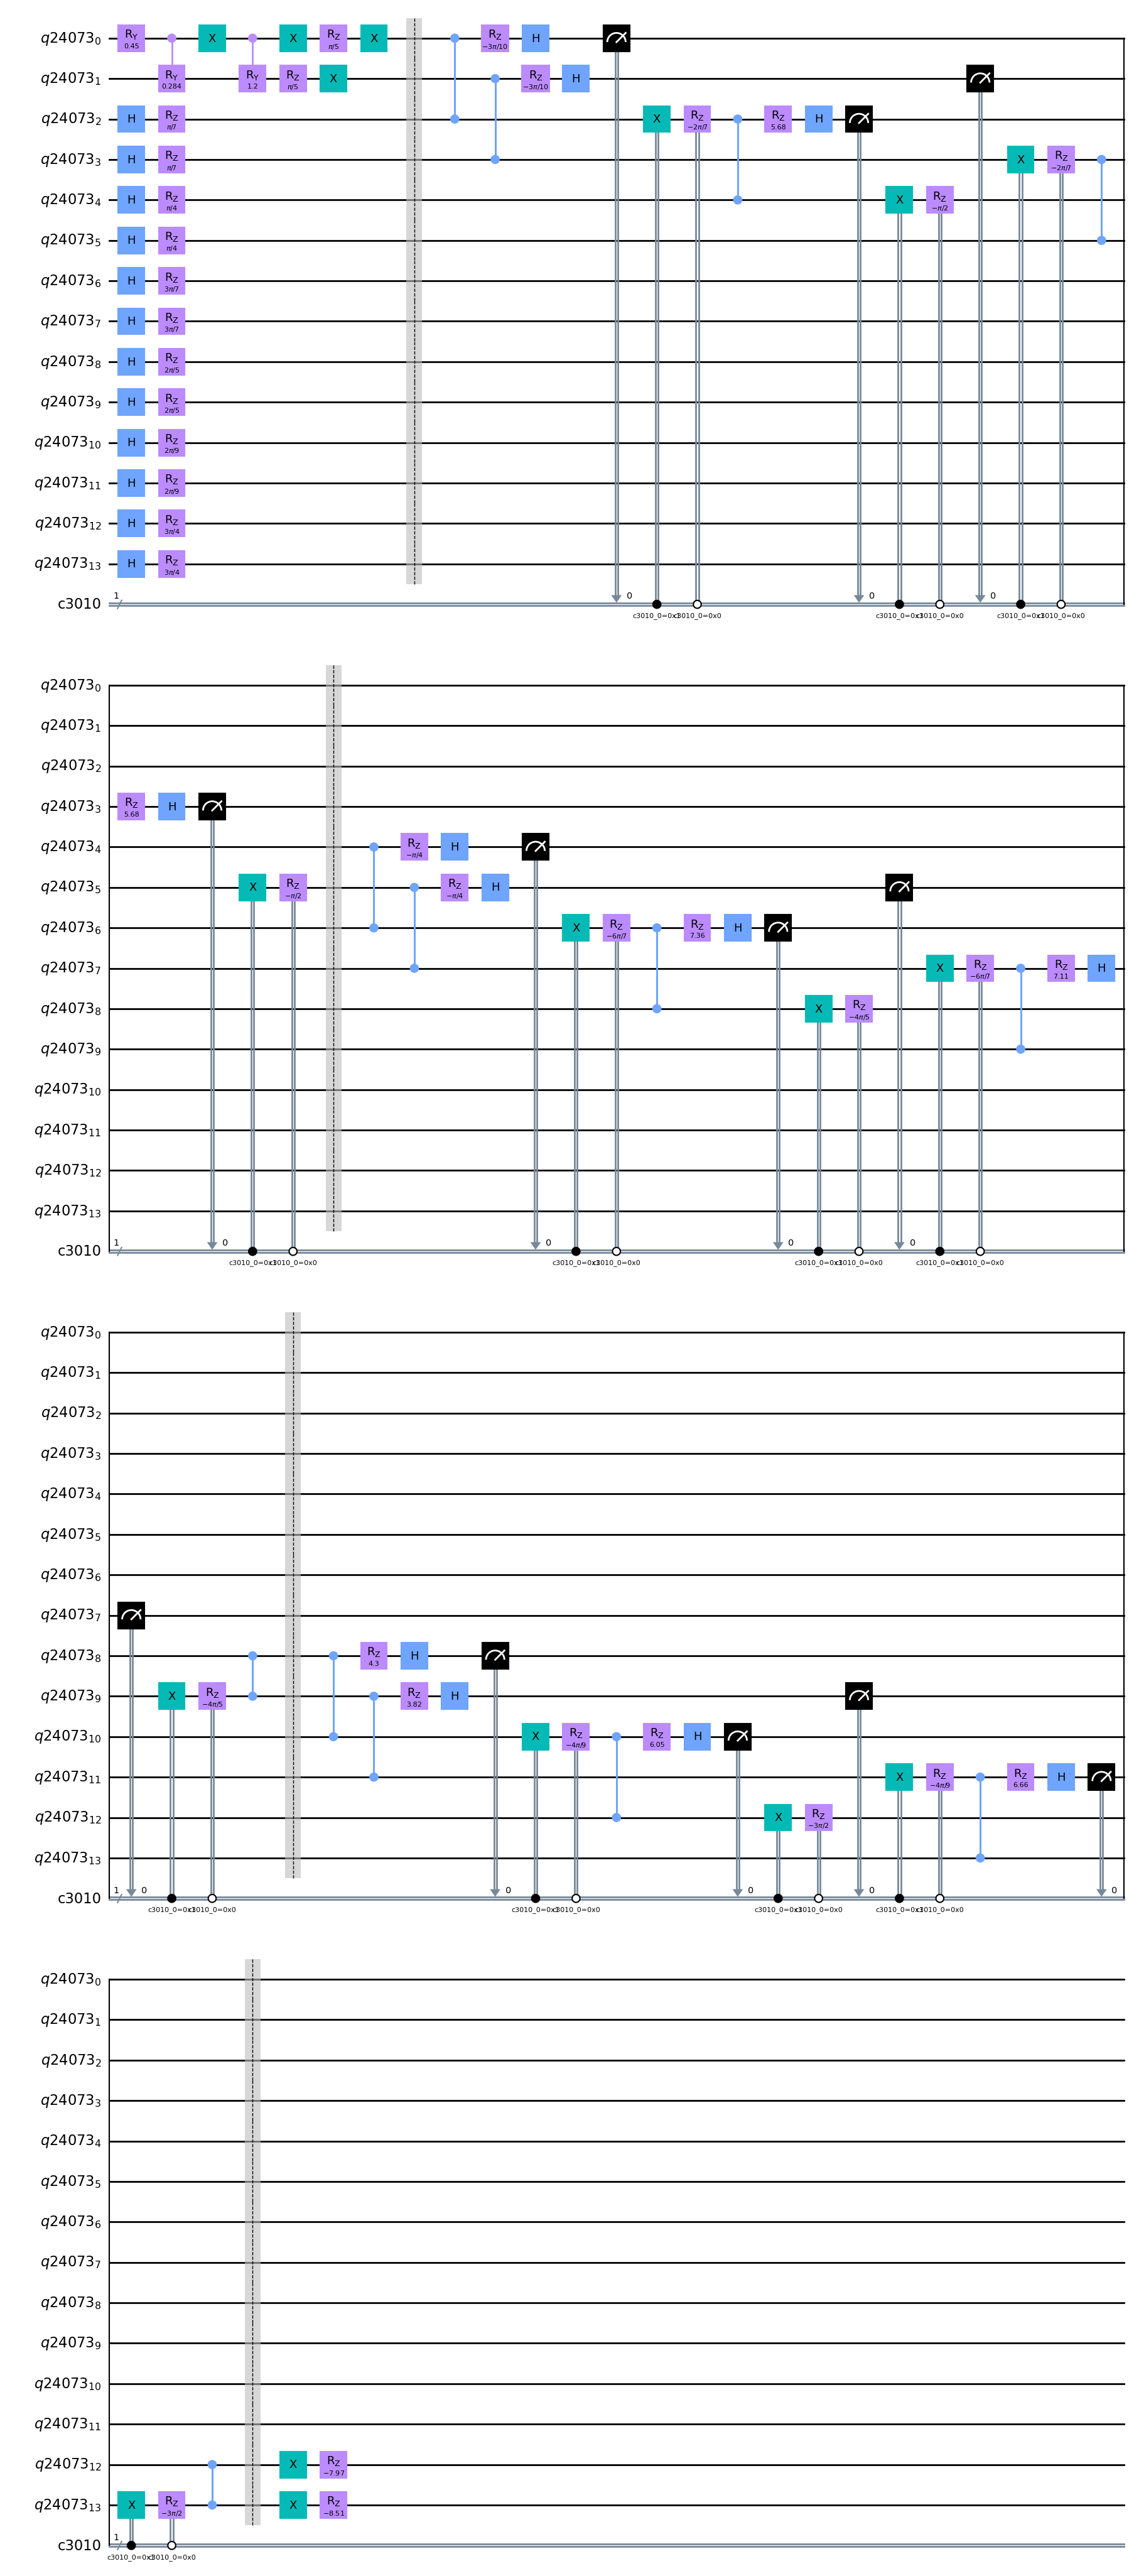

In [20]:
#  扩展电路
params = np.random.sample((4, 2, 1))
features = np.array([convertDataToAngles(i) for i in X_list])
qc = forwardPass(params, features[0])
qc.draw(output='mpl')

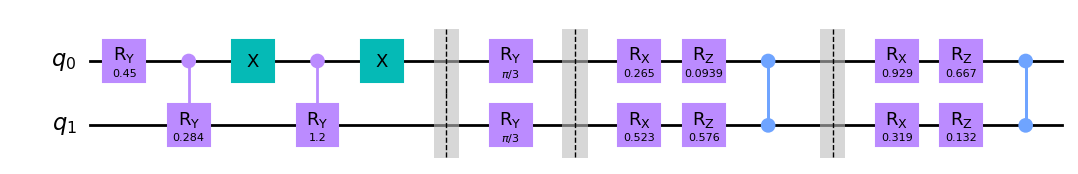

In [21]:
# 原始电路
qc1 = QuantumCircuit(2)
qc1.ry(features[0][0], 0)
qc1.cry(features[0][1], 0, 1)
qc1.x(0)
qc1.cry(features[0][2], 0, 1)
qc1.x(0)
qc1.barrier()
qc1.ry(np.pi/3,0)
qc1.ry(np.pi/3,1)
qc1.barrier()
qc1.rx(params[0][0][0],0)
qc1.rx(params[0][1][0],1)
qc1.rz(params[1][0][0],0)
qc1.rz(params[1][1][0],1)
qc1.cz(0,1)
qc1.barrier()
qc1.rx(params[2][0][0],0)
qc1.rx(params[2][1][0],1)
qc1.rz(params[3][0][0],0)
qc1.rz(params[3][1][0],1)
qc1.cz(0,1)
qc1.draw(output='mpl')